In [15]:
#Ref - https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
import pandas as pd
import numpy as np
import datetime
import talib as ta
import matplotlib.pyplot as plt
import seaborn as sns
import talib as ta

In [16]:
#Read data
data = pd.read_csv('data/analysis/D1_XAUUSD_Returns.csv', parse_dates=[0], index_col='Date')
#print(data.head())

In [17]:
#Date related features
data['Week'] = data.index.week
data['Day_Week'] = data.index.dayofweek
data['daily_return'] = data.Close.pct_change().mul(100)
data['day_week_sin'] = np.sin(data.Day_Week*(2.*np.pi/7))
data['day_week_cos'] = np.cos(data.Day_Week*(2.*np.pi/7))
data['week_sin'] = np.sin((data.Week-1)*(2.*np.pi/52))
data['week_cos'] = np.cos((data.Week-1)*(2.*np.pi/52))
data['yearday_sin'] = np.sin((data.Yearday)*(2.*np.pi/365.25))
data['yearday_cos'] = np.cos((data.Yearday)*(2.*np.pi/365.25))
#Simple Moving Average - 50 day
data['SMA_50'] = ta.SMA(data.Close, timeperiod = 50)
#Simple Moving Average - 200 day
data['SMA_200'] = ta.SMA(data.Close, timeperiod = 200)
# Exponential Moving Average - 9 day
data['EMA_9'] = ta.EMA(data.Close, timeperiod = 9)
# Exponential Moving Average - 21 day
data['EMA_21'] = ta.EMA(data.Close, timeperiod = 21)
# MACD
data['macd'], data['macdsignal'], data['macdhist'] = ta.MACD(data.Close, fastperiod=12, slowperiod=200, signalperiod=9)
# RSI
data['RSI'] = ta.RSI(data.Close, timeperiod=14)
#Define relative indicators
data['SMA_Delta'] = (data['SMA_50'] - data['SMA_200']) / data['Close']
#Define relative indicators
data['EMA_Delta'] = (data['EMA_9'] - data['EMA_21']) / data['Close']

In [18]:
print(data.tail())

               Open     High      Low    Close  Volume   Weekday  Yearday  \
Date                                                                        
2019-04-25  1274.63  1282.53  1273.31  1278.56   97134  Thursday      115   
2019-04-26  1278.56  1288.61  1273.72  1285.69  107326    Friday      116   
2019-04-28  1286.28  1286.62  1285.63  1285.80    1913    Sunday      118   
2019-04-29  1285.79  1286.57  1277.99  1280.33   80222    Monday      119   
2019-04-30  1280.32  1286.12  1279.84  1283.11  103615   Tuesday      120   

            Daily_return  Log_daily_Return  Week  ...     SMA_50     SMA_200  \
Date                                              ...                          
2019-04-25      0.308325          0.003079    17  ...  1295.9396  1260.27820   
2019-04-26      0.557659          0.005561    17  ...  1295.0698  1260.74670   
2019-04-28      0.008556          0.000086    17  ...  1294.3640  1261.19035   
2019-04-29     -0.425416         -0.004263    18  ...  1293.

In [19]:
#Choosing target variable
#data['Large_return'] = np.where(data['daily_return']>=0.5, 1, (np.where(data['daily_return']<=-0.5, -1, 0)))
data['Large_return'] = np.where(data['daily_return']>0, 1, 0)

In [20]:
#Drop rows with nan values
data.dropna(inplace=True)

In [21]:
#Pick features
features_list = ['Volume','day_week_sin','day_week_cos','week_sin','week_cos','yearday_sin','yearday_cos',
                 'macdhist', 'RSI', 'SMA_Delta','EMA_Delta']
features = data[features_list]
features.head()

,Volume,day_week_sin,day_week_cos,week_sin,week_cos,yearday_sin,yearday_cos,macdhist,RSI,SMA_Delta,EMA_Delta
Date,,,,,,,,,,,
2004-01-12,20736,0.000000,1.000000,0.239316,0.970942,0.204966,0.978769,2.239954,70.847411,0.071611,0.011534
2004-01-13,21473,0.781831,0.623490,0.239316,0.970942,0.221772,0.975099,1.835514,68.227339,0.072198,0.010996
2004-01-14,20415,0.974928,-0.222521,0.239316,0.970942,0.238513,0.971139,0.945729,57.107955,0.073547,0.009352
2004-01-15,22449,0.433884,-0.900969,0.239316,0.970942,0.255182,0.966893,-0.982156,39.857679,0.075568,0.005214
2004-01-16,19571,-0.433884,-0.900969,0.239316,0.970942,0.271777,0.962360,-2.539018,37.444023,0.076086,0.001362


In [22]:
#Pick target variable 
target_unshifted = data['Large_return']
#Add shift so we can predict target on time t=1 with features from time t
target = target_unshifted.shift(-1)
#Drop last value from features and target (Nan)
features = features[:-1]
target = target[:-1]
print(features.tail())
print(target.tail())

            Volume  day_week_sin  day_week_cos  week_sin  week_cos  \
Date                                                                 
2019-04-24   97655      0.974928     -0.222521  0.935016 -0.354605   
2019-04-25   97134      0.433884     -0.900969  0.935016 -0.354605   
2019-04-26  107326     -0.433884     -0.900969  0.935016 -0.354605   
2019-04-28    1913     -0.781831      0.623490  0.935016 -0.354605   
2019-04-29   80222      0.000000      1.000000  0.885456 -0.464723   

            yearday_sin  yearday_cos  macdhist        RSI  SMA_Delta  \
Date                                                                   
2019-04-24     0.924803    -0.380447 -6.111534  36.796126   0.029050   
2019-04-25     0.918121    -0.396299 -5.161771  41.209393   0.027892   
2019-04-26     0.911169    -0.412034 -3.540636  48.267119   0.026696   
2019-04-28     0.896456    -0.443132 -2.331190  48.370097   0.025800   
2019-04-29     0.888701    -0.458487 -2.080020  43.710538   0.025073   

    

In [23]:
def split_train_test(data, train_ratio):
    indices = np.arange(len(data))
    train_set_size = int(len(data) * train_ratio)
    train_indices = indices[:train_set_size]
    test_indices = indices[train_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

X_train_set, X_test_set = split_train_test(features, 0.8)

In [24]:
print(len(X_train_set))
print(len(X_test_set))
print("Training Series:", "\n", X_train_set.head(), "\n")
print("Training Series:", "\n", X_train_set.tail(), "\n")
print("Testing Series:", "\n", X_test_set.head())
print("Testing Series:", "\n", X_test_set.tail())

3816
955
Training Series: 
             Volume  day_week_sin  day_week_cos  week_sin  week_cos  \
Date                                                                 
2004-01-12   20736      0.000000      1.000000  0.239316  0.970942   
2004-01-13   21473      0.781831      0.623490  0.239316  0.970942   
2004-01-14   20415      0.974928     -0.222521  0.239316  0.970942   
2004-01-15   22449      0.433884     -0.900969  0.239316  0.970942   
2004-01-16   19571     -0.433884     -0.900969  0.239316  0.970942   

            yearday_sin  yearday_cos  macdhist        RSI  SMA_Delta  \
Date                                                                   
2004-01-12     0.204966     0.978769  2.239954  70.847411   0.071611   
2004-01-13     0.221772     0.975099  1.835514  68.227339   0.072198   
2004-01-14     0.238513     0.971139  0.945729  57.107955   0.073547   
2004-01-15     0.255182     0.966893 -0.982156  39.857679   0.075568   
2004-01-16     0.271777     0.962360 -2.539018  3

In [25]:
y_train_set, y_test_set = split_train_test(target, 0.8)

In [26]:
#SKIP
print(len(y_train_set))
print(len(y_test_set))
print("Training Series:", "\n", y_train_set.head(), "\n")
print("Training Series:", "\n", y_train_set.tail(), "\n")
print("Testing Series:", "\n", y_test_set.head())
print("Testing Series:", "\n", y_test_set.tail())

3816
955
Training Series: 
 Date
2004-01-12    0.0
2004-01-13    0.0
2004-01-14    0.0
2004-01-15    0.0
2004-01-16    0.0
Name: Large_return, dtype: float64 

Training Series: 
 Date
2016-03-28    1.0
2016-03-29    0.0
2016-03-30    1.0
2016-03-31    0.0
2016-04-01    0.0
Name: Large_return, dtype: float64 

Testing Series: 
 Date
2016-04-03    0.0
2016-04-04    1.0
2016-04-05    0.0
2016-04-06    1.0
2016-04-07    1.0
Name: Large_return, dtype: float64
Testing Series: 
 Date
2019-04-24    1.0
2019-04-25    1.0
2019-04-26    1.0
2019-04-28    0.0
2019-04-29    1.0
Name: Large_return, dtype: float64


In [57]:
#Scale test and train data
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()

X_train_norm = min_max_scaler.fit_transform(X_train_set)
X_test_norm = min_max_scaler.fit_transform(X_test_set)

C:\Users\mbeca\Continuum\anaconda3\envs\keras\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\mbeca\Continuum\anaconda3\envs\keras\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [59]:
X_train_final = X_train_norm.reshape((X_train_norm.shape[0], 1, X_train_norm.shape[1]))
X_test_final = X_test_norm.reshape((X_test_norm.shape[0], 1, X_test_norm.shape[1]))
print(X_train_final.shape)
print(X_test_final.shape)

(3816, 1, 11)
(955, 1, 11)


In [89]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(X_train_final.shape[1], X_train_final.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
# fit network
history = model.fit(X_train_final, y_train_set, epochs=60, batch_size=100, validation_data=(X_test_final, y_test_set), verbose=2, shuffle=False)

Train on 3816 samples, validate on 955 samples
Epoch 1/60
 - 3s - loss: 0.5290 - acc: 0.4693 - val_loss: 0.5202 - val_acc: 0.4618
Epoch 2/60
 - 0s - loss: 0.5141 - acc: 0.4633 - val_loss: 0.5088 - val_acc: 0.4712
Epoch 3/60
 - 0s - loss: 0.5038 - acc: 0.4817 - val_loss: 0.4928 - val_acc: 0.5099
Epoch 4/60
 - 0s - loss: 0.4896 - acc: 0.5280 - val_loss: 0.4900 - val_acc: 0.5141
Epoch 5/60
 - 0s - loss: 0.4912 - acc: 0.5314 - val_loss: 0.4877 - val_acc: 0.5277
Epoch 6/60
 - 0s - loss: 0.4893 - acc: 0.5294 - val_loss: 0.4867 - val_acc: 0.5288
Epoch 7/60
 - 0s - loss: 0.4867 - acc: 0.5278 - val_loss: 0.4858 - val_acc: 0.5351
Epoch 8/60
 - 0s - loss: 0.4848 - acc: 0.5296 - val_loss: 0.4850 - val_acc: 0.5382
Epoch 9/60
 - 0s - loss: 0.4836 - acc: 0.5294 - val_loss: 0.4841 - val_acc: 0.5372
Epoch 10/60
 - 0s - loss: 0.4824 - acc: 0.5296 - val_loss: 0.4834 - val_acc: 0.5382
Epoch 11/60
 - 0s - loss: 0.4817 - acc: 0.5296 - val_loss: 0.4827 - val_acc: 0.5382
Epoch 12/60
 - 0s - loss: 0.4808 - acc

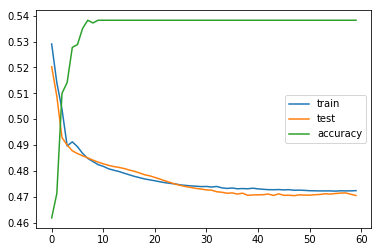

In [90]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.plot(history.history['val_acc'], label='accuracy')
plt.legend()
plt.show()